# **Softmax Regression for MNIST Handwritten Digit Classification**
Huy G. Tong\
*Faculty of Information Technology, VNUHCM - University of Science, Vietnam*

## **ABSTRACT**

## **IMPLEMENTATION**
First and foremost, let us import the necessary libraries. Run the bellow cell **AT LEAST ONCE** when working with this Notebook.

In [2]:
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...

In [3]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


In [4]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 0.99609375


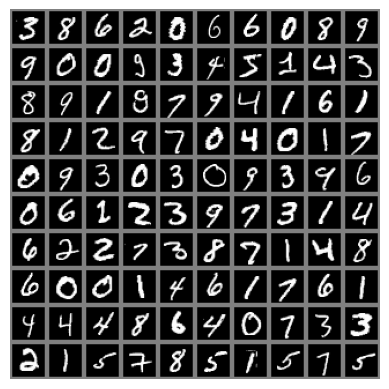

In [5]:
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.grid(None); plt.axis('off');

In [6]:
values, counts = np.unique(train_y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value}, count: {count}')

Value: 0, count: 4932
Value: 1, count: 5678
Value: 2, count: 4968
Value: 3, count: 5101
Value: 4, count: 4859
Value: 5, count: 4506
Value: 6, count: 4951
Value: 7, count: 5175
Value: 8, count: 4842
Value: 9, count: 4988


In [7]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

train_Z = add_ones(train_X)
train_Z.shape

(50000, 785)

In [8]:
def compute_smreg_output(W, X, return_prob=True):
    y = X @ W
    p = np.exp(y) / np.sum(np.exp(y), axis=1, keepdims=True)
    if return_prob: return p
    return np.argmax(p, axis=1)

In [11]:


def onehot(y):
    encoded = np.zeros((y.shape[0], y.max() + 1))
    encoded[np.arange(len(y)), y] = 1
    return encoded


def train_smreg(X, y, lr, max_epoch, initial_W=None):

    W = initial_W
    if W is None:
        W = np.zeros((X.shape[1], len(np.unique(y))))

    # Cross-entropy Errors
    cees = []
    
    # Add extra loop to compute cross-entropy errors
    for i in range(max_epoch + 1):
        y_pred = compute_smreg_output(W, X)

        # Ignore error of initial pass
        if i > 0:
            ce_error = -1.*np.sum(onehot(y)*np.log(y_pred))/X.shape[0]
            cees.append(ce_error)

        # Gradient descent step
        if i < max_epoch:
            dE = (X.T @ (y_pred - onehot(y))) / X.shape[0]
            W -= lr*dE

    return W, cees

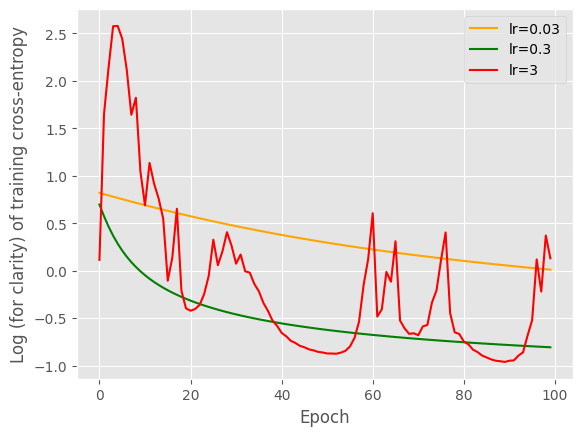

In [13]:
W_1a, train_ces_1a = train_smreg(train_Z, train_y, lr=0.03, max_epoch=100)
W_1b, train_ces_1b = train_smreg(train_Z, train_y, lr=0.3, max_epoch=100)
W_1c, train_ces_1c = train_smreg(train_Z, train_y, lr=3, max_epoch=100)

plt.plot(np.log(train_ces_1a), label='lr=0.03', color='orange')
plt.plot(np.log(train_ces_1b), label='lr=0.3', color='green')
plt.plot(np.log(train_ces_1c), label='lr=3', color='red')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')
plt.legend();

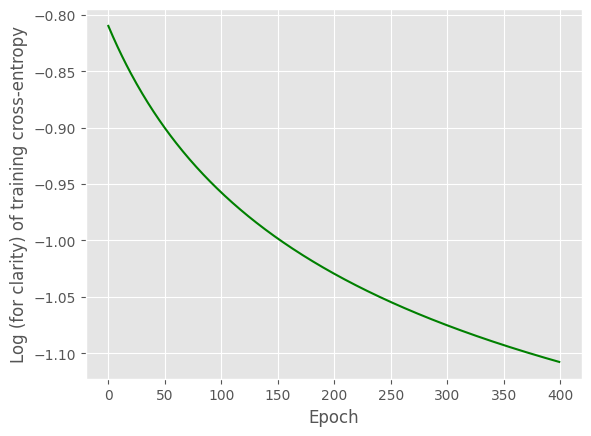

In [14]:
W_1, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=400, initial_W=W_1b)

plt.plot(np.log(train_ces), color='green')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

Có vẻ là nếu ta tiếp tục chạy thì độ lỗi cross-entropy sẽ còn giảm nữa, nhưng thôi, trong bài này ta sẽ tạm dừng ở đây vì laptop của mình bắt đầu kêu rồi ...

In [15]:
predicted_train_y = compute_smreg_output(W_1, train_Z, return_prob=False)

In [16]:
def compute_mbe(predicted_y, y):
    return np.mean(predicted_y != y) * 100

In [17]:
train_mbe = compute_mbe(predicted_train_y, train_y)
train_mbe

In [19]:
def add_features(X, mins=None, maxs=None):
    intensity = np.mean(X, axis=1, keepdims=True)
    
    # Get the images
    imgs = X.reshape((X.shape[0], 28, 28))
    flipped_h = np.flip(imgs, axis=2)
    flipped_v = np.flip(imgs, axis=1)

    s1 = np.mean(np.abs(imgs - flipped_h), axis=(1, 2))
    s2 = np.mean(np.abs(imgs - flipped_v), axis=(1, 2))
    symmetry = -1.*(s1 + s2)/2
    symmetry = np.expand_dims(symmetry, axis=1)

    if mins is None or maxs is None:
        mins = np.array([intensity.min(), symmetry.min()])
        maxs = np.array([intensity.max(), symmetry.max()])

        # Normalize
        intensity = (intensity - mins[0]) / (maxs[0] - mins[0])
        symmetry = (symmetry - mins[1]) / (maxs[1] - mins[1])

        Z = np.concatenate([X, intensity, symmetry], axis=1)

        return Z, mins, maxs

    # Normalize
    intensity = (intensity - mins[0]) / (maxs[0] - mins[0])
    symmetry = (symmetry - mins[1]) / (maxs[1] - mins[1])

    Z = np.concatenate([X, intensity, symmetry], axis=1)

    return Z

In [21]:
train_Z, mins_for_add_features, maxs_for_add_features = add_features(train_X)
train_Z = add_ones(train_Z)
train_Z.shape

(50000, 787)

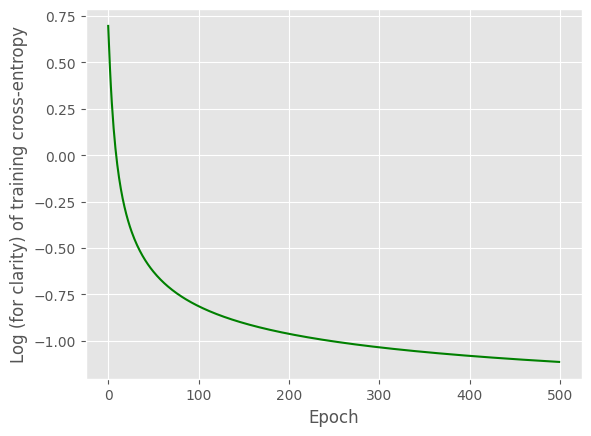

In [22]:
W_2, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=500)

plt.plot(np.log(train_ces), color='green')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

In [23]:
predicted_train_y = compute_smreg_output(W_2, train_Z, return_prob=False)
train_mbe = compute_mbe(predicted_train_y, train_y)

## Tiền xử lý dữ liệu validation, dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu validation và đánh giá kết quả

In [24]:
val_Z = add_ones(add_features(val_X, mins_for_add_features, maxs_for_add_features))
predicted_val_y = compute_smreg_output(W_2, val_Z, return_prob=False)
val_mbe = compute_mbe(predicted_val_y, val_y)
assert str(np.round(val_mbe, 4)) == '8.27'

Độ lỗi MBE trên dữ liệu validation cũng giảm theo: giảm từ 8.36 xuống 8.27.

## Chọn ra cách tiền xử lý + mô hình Softmax Regression sau cùng là cách tiền xử lý + mô hình Softmax Regression mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation

Như vậy ta sẽ chọn cách tiền xử lý là `add_ones(add_features(..., mins_for_add_features, maxs_for_add_features))` và mô hình Softmax Regression có bộ trọng số là `W_2`.

## Dùng cách tiền xử lý + mô hình Softmax Regression sau cùng để đi thi thật!

In [25]:
test_Z = add_ones(add_features(test_X, mins_for_add_features, maxs_for_add_features))
predicted_test_y = compute_smreg_output(W_2, test_Z, return_prob=False)
test_mbe = compute_mbe(predicted_test_y, test_y)
assert str(np.round(test_mbe, 4)) == '8.6'

5


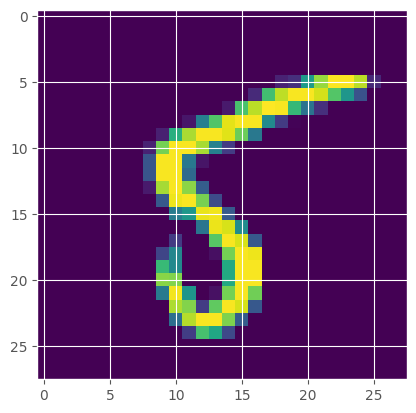

In [29]:
# Draw some images for fun
i = np.random.randint(0, high=test_X.shape[0] + 1)
img = test_X[i]
label = predicted_test_y[i]
img = img.reshape((28, 28))

print(label)

plt.imshow(img)
plt.show()

Giờ thì đi ngủ được rồi ...